# Relazione – Laboratori di Data Science (Algebra Lineare)

Questa relazione raccoglie lo svolgimento degli esercizi del **Foglio 1 – Algebra Lineare** 
del corso di Data Science (Laurea in Scienza dei Materiali, Alma Mater Studiorum – Università di Bologna, 
a.a. 2025/2026).

Per maggiori dettagli, si rimanda alla repository GitHub:  
🔗 [Laboratori-Data-Science](https://github.com/CetrioloRiick/Laboratori-Data-Science.git)


## Esercizio 1

### 1a

Il codice svolge i seguenti passaggi principali:

- Calcola **autovalori e autovettori** della matrice \(A\), necessari per applicare la formula di diagonalizzazione.
- Genera un vettore di tempi \(t\) equispaziati nell’intervallo \([0,5]\) attraverso il metodo `linspace`.  
- Per ciascun valore di \(t\), costruisce la **matrice esponenziale** corrispondente.  
- Raccoglie tutti i risultati in un array tridimensionale, dove ogni “strato” rappresenta \(e^{At}\) a un certo istante.  
- Si sfrutta la combinazione di **Matplotlib** e della gestione di array multidimensionali offerta da **NumPy**, che consente di organizzare i risultati come un contenitore (tensoriale) di matrici e selezionare agevolmente i singoli elementi da plottare.

**Nota** nel calcolo degli autovalori la parte immaginaria viene troncata in quanto "piccola", nel caso questo non avenisse matplotlib segnalerrebbe il casting di ques'utima non sapendola rapressentare sul pianto

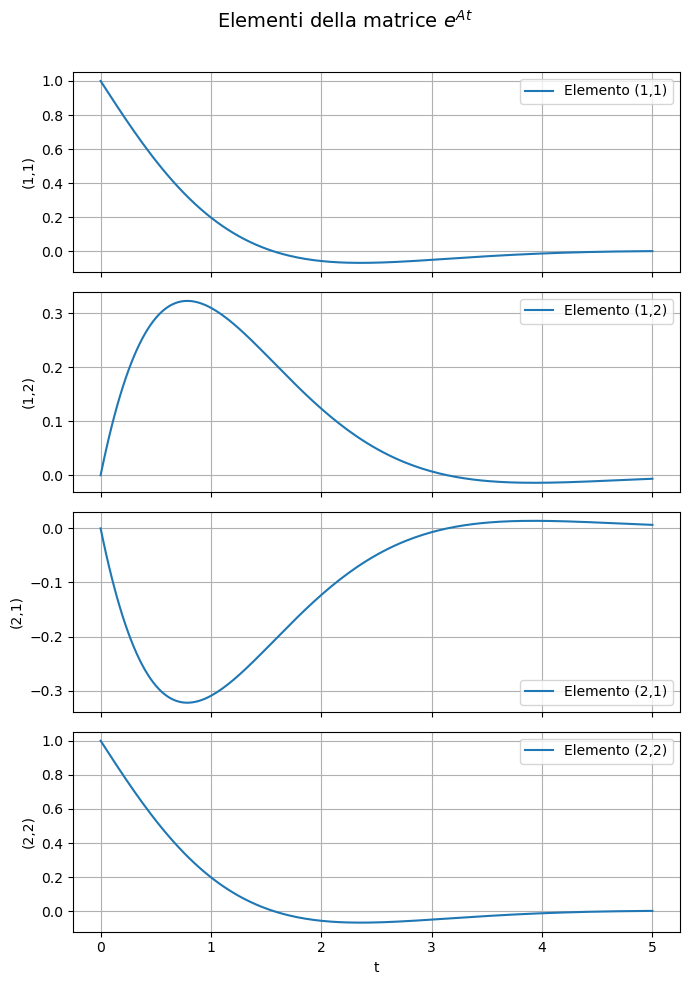

Autovalori: [-1.+1.j -1.-1.j]
Autovettori (colonne di P):
 [[0.70710678+0.j         0.70710678-0.j        ]
 [0.        +0.70710678j 0.        -0.70710678j]]


In [1]:
import numpy as np
import matplotlib.pyplot as plt

A = np.array([[-1, 1], [-1, -1]], dtype=float)

eigvals, P = np.linalg.eig(A)
inv_P = np.linalg.inv(P)

t = np.linspace(0, 5, 200)

E_list = []
for ti in t:
    Dti = np.diag(np.exp(eigvals * ti))
    Eti = P @ Dti @ inv_P
    Eti = np.real_if_close(Eti)
    E_list.append(Eti)

E = np.stack(E_list, axis=0)

fig, ax = plt.subplots(4, 1, figsize=(7, 10), sharex=True)

labels = ["(1,1)", "(1,2)", "(2,1)", "(2,2)"]
indices = [(0, 0), (0, 1), (1, 0), (1, 1)]

for i, (row, col) in enumerate(indices):
    ax[i].plot(t, E[:, row, col], label=f"Elemento {labels[i]}")
    ax[i].legend(loc="best")
    ax[i].grid(True)
    ax[i].set_ylabel(f"{labels[i]}")

ax[-1].set_xlabel("t")
fig.suptitle("Elementi della matrice $e^{At}$", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

print("Autovalori:", eigvals)
print("Autovettori (colonne di P):\n", P)

### 1b

Il codice svolge i seguenti passaggi principali:

- Si definisce un insieme di dimensioni delle matrici (`N`) da 3 a 200.  
- Per ogni `n`, si creano `s=100` matrici quadrate con elementi gaussiani di deviazione `σ=1.0`.  
- Si calcolano gli autovalori complessi di ciascuna matrice con
- Gli autovalori vengono normalizzati dividendo parte reale e immaginaria per `√n`.  
- Si ottiene così la distribuzione scalata degli autovalori, utile per confronti tra dimensioni diverse.  
- Per ogni valore di `n`, si produce un grafico degli autovalori nel piano complesso.  

**Nota** Se non si dividono gli autovalori per `√n` questi tenderanno a crescere con la dimensione della matrice, per evitare questo problema bisogna cambiare il sigma della gaussiana in modo che diventi più piccolo all'aumentare di n: `σ=1/n`

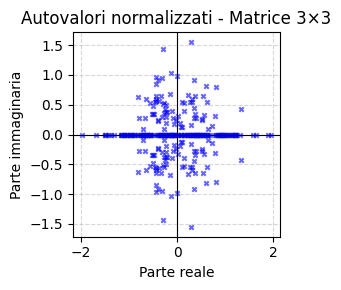

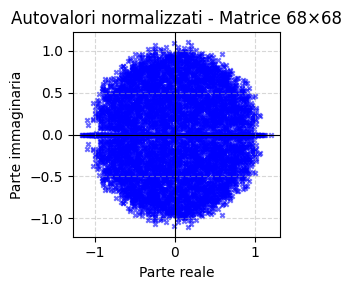

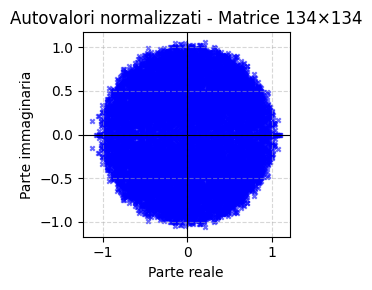

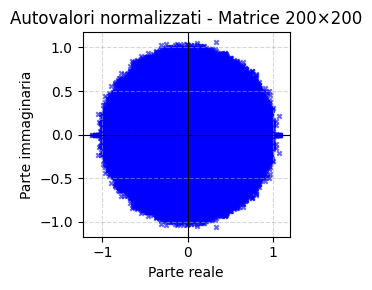

In [1]:
import numpy as np
import matplotlib.pyplot as plt

N = np.linspace(3, 200, 4, dtype=int)
s = 100
sigma = 1.0
matrices_list = [np.random.normal(0.0, sigma, size=(s, n, n)) for n in N]

eigvals_list = [np.linalg.eigvals(mat) for mat in matrices_list]

eigvals_scaled = [
    (eig.real / np.sqrt(n), eig.imag / np.sqrt(n)) for n, eig in zip(N, eigvals_list)
]

for n, (x, y) in zip(N, eigvals_scaled):
    plt.figure(figsize=(3, 3))
    plt.scatter(x, y, color="blue", marker="x", s=10, alpha=0.6)
    plt.axhline(0, color="black", linewidth=0.8)
    plt.axvline(0, color="black", linewidth=0.8)
    plt.xlabel("Parte reale")
    plt.ylabel("Parte immaginaria")
    plt.title(f"Autovalori normalizzati - Matrice {n}×{n}")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()

plt.show()

### 1c

Il codice svolge i seguenti passaggi principali:

- Utilizzando i metodi della librerua ase, si apre il file `dataset.xyz`
- Si calcola il centro di massa per ogni molecola, torna comoda la funzione `average` per la media pesata.  
- Per ogni ogni molecola si calcola il momento di inerzia, si salvano nella lista I.  
- Si trovano gli autovalori di I.
- Vengono salvati e ordinati i momenti di inerzia principali nella lista `eigvals`.
- Si classifica la geometria di ogni molecola e si memorizzano i risultati in un dizionario.

In [2]:
from ase import Atoms
from ase.io import write, read
import numpy as np


def calc_diag_val(x: np.ndarray, y: np.ndarray, m: np.ndarray) -> float:
    return np.sum(m * (np.square(x) + np.square(y)))


def calc_off_val(x: np.ndarray, y: np.ndarray, m: np.ndarray) -> float:
    return -np.sum(m * x * y)


def classify_eigs(vals: np.ndarray, atol: float = 1.0) -> str:
    a, b, c = vals
    if np.isclose(a, b, atol=atol) and np.isclose(b, c, atol=atol):
        return "Sferica"
    if np.isclose(a, b, atol=atol) and b < c:
        return "Oblata"
    if a < b and np.isclose(b, c, atol=atol):
        return "Prolata"
    if a < b < c:
        return "Asimmetrica"
    return "Asimmetrica"


DataSet = read("dataset.xyz", index=":")
masses = [atom.get_masses() for atom in DataSet]
positions = [atom.get_positions() for atom in DataSet]
n = len(positions)

centers_of_mass = [
    np.average(pos, axis=0, weights=mass) for pos, mass in zip(positions, masses)
]

positions_cm = [pos - com for pos, com in zip(positions, centers_of_mass)]

I = []
for pos, mass in zip(positions_cm, masses):
    x, y, z = pos[:, 0], pos[:, 1], pos[:, 2]
    xx = calc_diag_val(y, z, mass)
    yy = calc_diag_val(x, z, mass)
    zz = calc_diag_val(x, y, mass)
    xy = calc_off_val(x, y, mass)
    yz = calc_off_val(y, z, mass)
    xz = calc_off_val(x, z, mass)

    i = np.array([[xx, xy, xz], [xy, yy, yz], [xz, yz, zz]], dtype=float)
    I.append(i)


eigvals = [np.sort(np.linalg.eigvals(i)) for i in I]

counts = {"Sferica": 0, "Oblata": 0, "Prolata": 0, "Asimmetrica": 0}
for vals in eigvals:
    counts[classify_eigs(vals, atol=1.0)] += 1

total = len(eigvals)
print("Molecole analizzate: ", total, "\n")
for k in ("Sferica", "Oblata", "Prolata", "Asimmetrica"):
    n = counts[k]
    perc = n / total * 100.0
    print(f"{k:>12}: {n:4d}  ({perc:6.2f}%)")


Molecole analizzate:  7165 

     Sferica:    2  (  0.03%)
      Oblata:   10  (  0.14%)
     Prolata:   21  (  0.29%)
 Asimmetrica: 7132  ( 99.54%)


## Esercizio 2

### 2a

